In [ ]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf

- GBM: Simple, good for short-term forecasting
- Heston: Better for options pricing, captures volatility smiles
- GARCH: Good for risk management, captures volatility clustering
- OU: Good for mean-reverting pairs
- CEV: Good for capturing asymmetric volatility
- Merton Jump diffusion model (supposed to be the best)

Merton Jump diffusion model

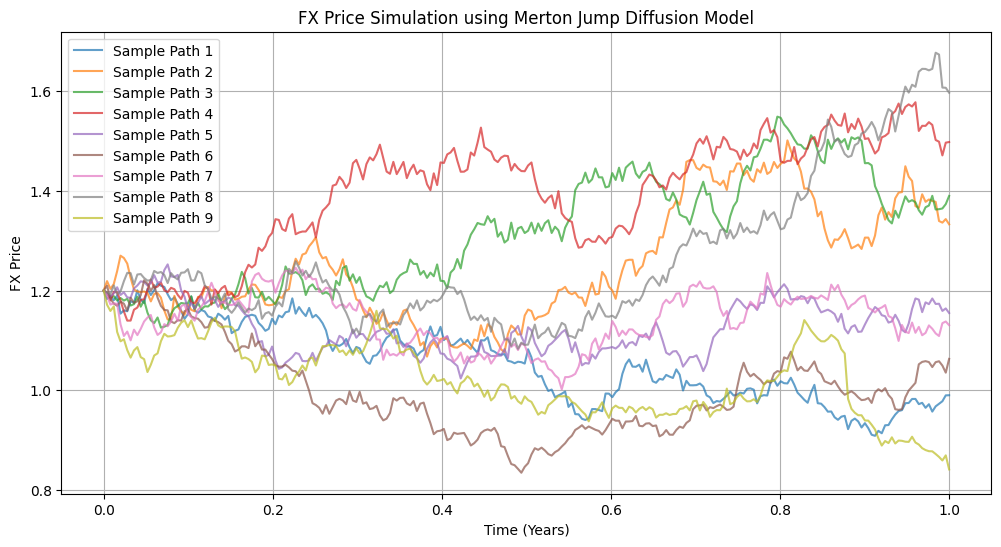

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def merton_jump(S0, mu, sigma, lambda_, mu_j, sigma_j, T, steps):
    dt = T / steps
    price_path = np.zeros(steps)
    price_path[0] = S0
    time = np.linspace(0, T, steps)

    for t in range(1, steps):
        # Simulate Brownian motion
        dW = np.random.normal(0, np.sqrt(dt))

        # Simulate Poisson jumps
        N_t = np.random.poisson(lambda_ * dt)
        if N_t > 0:
            # Generate jumps only if N_t > 0
            jumps = np.random.normal(mu_j, sigma_j, N_t)
            jump_component = np.sum(jumps)
        else:
            jump_component = 0

        # Calculate the total return
        drift = (mu - lambda_*(np.exp(mu_j + 0.5*sigma_j**2) - 1) - 0.5*sigma**2) * dt
        diffusion = sigma * dW

        # Update price using the full jump-diffusion equation
        price_path[t] = price_path[t-1] * np.exp(drift + diffusion + jump_component)

    return time, price_path

# Parameters
S0 = 1.2          # Initial FX price
mu = 0.05         # Drift (average return)
sigma = 0.2       # Volatility
lambda_ = 0.3     # Jump intensity (jumps per year)
mu_j = -0.02      # Mean jump size (log-normal mean)
sigma_j = 0.1     # Std dev of jump size (log-normal)
T = 1             # Total time (in years)
steps = 252       # Number of steps (e.g., daily over a year)

# Simulate multiple paths to demonstrate the behavior
plt.figure(figsize=(12, 6))
for i in range(9):  # Generate 3 sample paths
    time, price_path = merton_jump(S0, mu, sigma, lambda_, mu_j, sigma_j, T, steps)
    plt.plot(time, price_path, label=f"Sample Path {i+1}", alpha=0.7)

plt.title("FX Price Simulation using Merton Jump Diffusion Model")
plt.xlabel("Time (Years)")
plt.ylabel("FX Price")
plt.legend()
plt.grid(True)
plt.show()

Geometric Brownian Motion (GBM)

Stochastic Processes are ideal for understanding the probabilistic nature of stock price evolution, especially in the context of financial modeling, derivative pricing, and risk analysis.

Use Stochastic Processes when:

- You want to model the random evolution of stock prices, for example, when you’re pricing financial derivatives (options), modeling risk, or simulating multiple potential future price paths.
- You're interested in modeling stock prices continuously and understand that price movements are governed by random factors like volatility and external shocks.


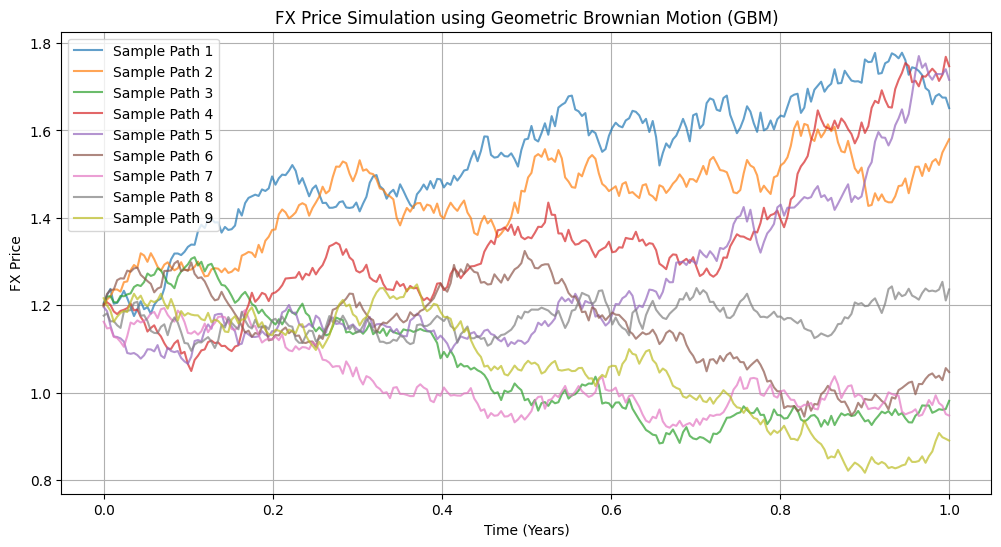

In [ ]:
def gbm(S0, mu, sigma, T, steps):
    dt = T/steps
    dW = np.random.normal(0, np.sqrt(dt), steps)
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * dW
    S = S0 * np.exp(np.cumsum(drift + diffusion))
    return S

plt.figure(figsize=(12, 6))
for i in range(9):
    S = gbm(S0, mu, sigma, T, steps)
    plt.plot(time, S, label=f"Sample Path {i+1}", alpha=0.7)

plt.title("FX Price Simulation using Geometric Brownian Motion (GBM)")
plt.xlabel("Time (Years)")
plt.ylabel("FX Price")
plt.legend()
plt.grid(True)
plt.show()


Heston Stochastic Volatility Model - Better for capturing volatility clustering

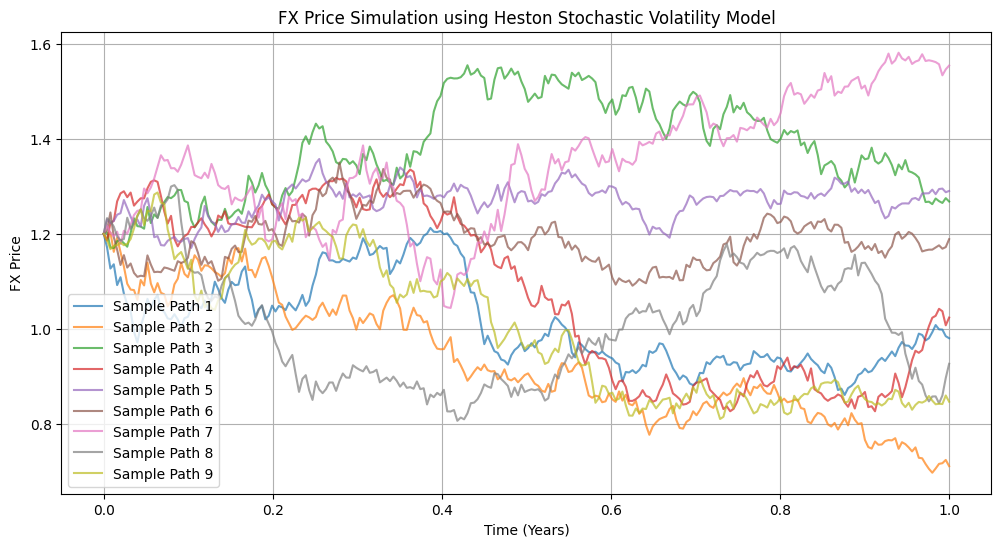

In [ ]:
def heston(S0, v0, kappa, theta, xi, rho, mu, T, steps):
    dt = T/steps
    prices = np.zeros(steps)
    vol = np.zeros(steps)
    prices[0] = S0
    vol[0] = v0

    for t in range(1, steps):
        dW1 = np.random.normal(0, np.sqrt(dt))
        dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt))

        vol[t] = vol[t-1] + kappa*(theta - vol[t-1])*dt + xi*np.sqrt(vol[t-1])*dW2
        vol[t] = max(0, vol[t])  # Ensure volatility stays positive

        prices[t] = prices[t-1] * np.exp((mu - 0.5*vol[t])*dt + np.sqrt(vol[t])*dW1)

    return prices

# Parameters for Heston Model
S0 = 1.2          # Initial FX price
mu = 0.05         # Drift (average return)
v0 = 0.1         # Initial volatility # This line was added to initialize v0
kappa = 2.0       # Mean reversion speed
theta = 0.04      # Long-term volatility
xi = 0.3          # Volatility of volatility
rho = -0.7        # Correlation between the two Brownian motions
T = 1             # Total time (in years)
steps = 252       # Number of steps (e.g., daily over a year)

plt.figure(figsize=(12, 6))
for i in range(9):
    S = heston(S0, v0, kappa, theta, xi, rho, mu, T, steps)
    plt.plot(time, S, label=f"Sample Path {i+1}", alpha=0.7)

plt.title("FX Price Simulation using Heston Stochastic Volatility Model")
plt.xlabel("Time (Years)")
plt.ylabel("FX Price") # This line was added to include y-axis label
plt.legend()
plt.grid(True)
plt.show()

GARCH Model - Good for capturing volatility clustering and fat tails

Time Series is more suitable for tasks like trend forecasting, anomaly detection, and understanding historical behavior.

Use Time Series Analysis when:

- You have discrete observed data (e.g., daily closing prices) and are primarily interested in forecasting future values or understanding trends and patterns in the data.
- You're more concerned with making predictions based on historical data rather than modeling the underlying randomness of the system.

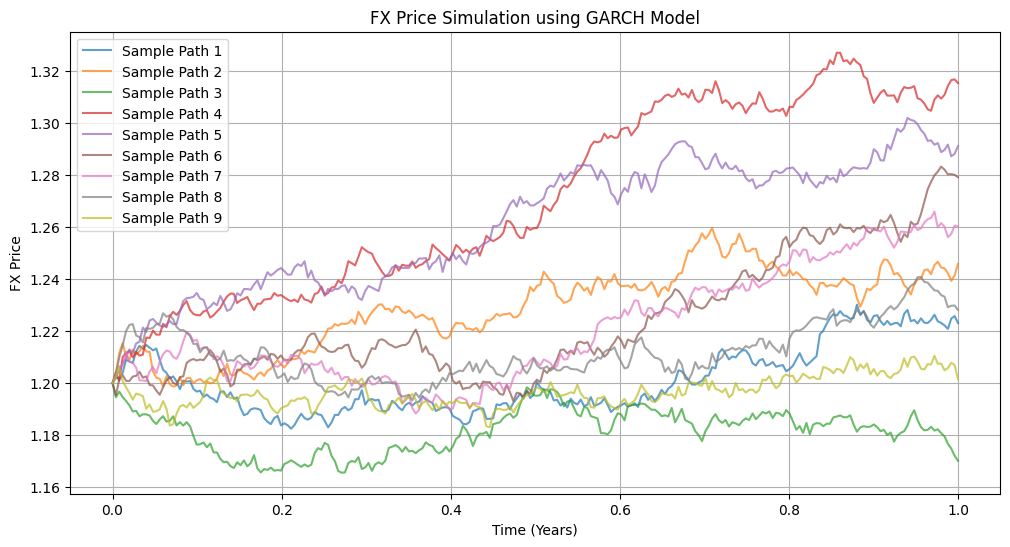

In [ ]:
def garch(S0, omega, alpha, beta, mu, sigma_scale, T, steps):
    dt = T/steps
    returns = np.zeros(steps)
    sigma2 = np.zeros(steps)
    prices = np.zeros(steps)
    prices[0] = S0

    # Initialize with more realistic initial variance
    sigma2[0] = omega/(1 - alpha - beta)

    for t in range(1, steps):
        z = np.random.normal(0, 1)

        # Update conditional variance with scaling factor
        sigma2[t] = omega + alpha*(returns[t-1]**2) + beta*sigma2[t-1]

        # Calculate returns with reduced drift and increased volatility
        returns[t] = (mu - 0.5*sigma2[t])*dt + np.sqrt(sigma2[t]*dt)*sigma_scale*z

        # Update prices using log-returns
        prices[t] = prices[t-1] * np.exp(returns[t])

    return prices

# Adjusted Parameters for more realistic FX movements
S0 = 1.2          # Initial FX price
mu = 0.02         # Reduced drift (annualized)
omega = 0.00004   # Increased base volatility
alpha = 0.15      # Increased ARCH effect
beta = 0.80       # Slightly reduced persistence
sigma_scale = 2.0 # Volatility scaling factor
T = 1             # Time horizon in years
steps = 252       # Number of steps (trading days)

# Create time array
time = np.linspace(0, T, steps)

# Set random seed for reproducibility
np.random.seed(42)

# Simulate multiple paths
plt.figure(figsize=(12, 6))
for i in range(9):
    prices = garch(S0, omega, alpha, beta, mu, sigma_scale, T, steps)
    plt.plot(time, prices, label=f"Sample Path {i+1}", alpha=0.7)

plt.title("FX Price Simulation using GARCH Model")
plt.xlabel("Time (Years)")
plt.ylabel("FX Price")
plt.legend()
plt.grid(True)
plt.show()

Ornstein-Uhlenbeck (Mean-Reverting) Model - Useful for currency pairs that tend to mean-revert

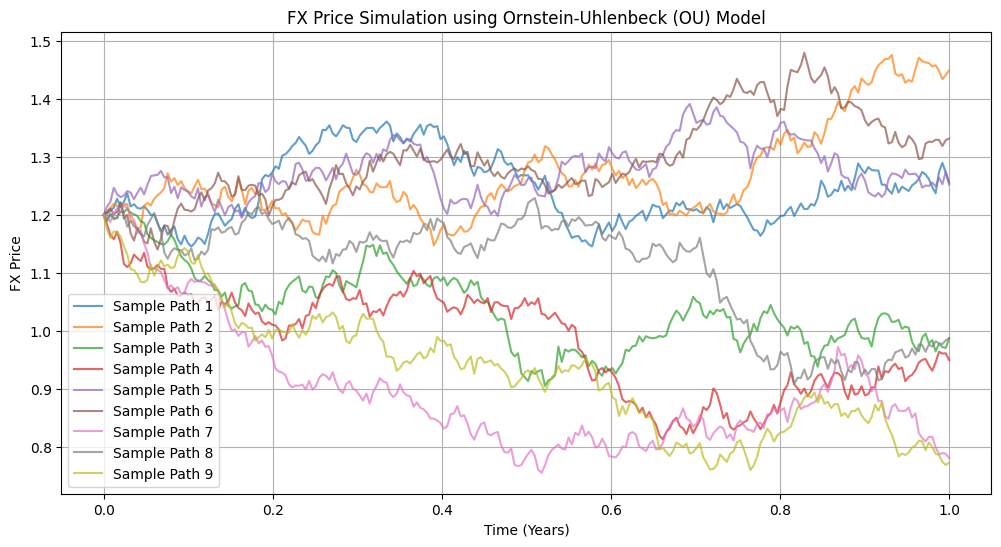

In [ ]:
def ou(S0, mu, theta, sigma, T, steps):
    dt = T/steps
    prices = np.zeros(steps)
    prices[0] = S0

    for t in range(1, steps):
        dW = np.random.normal(0, np.sqrt(dt))
        prices[t] = prices[t-1] + theta*(mu - prices[t-1])*dt + sigma*dW

    return prices

plt.figure(figsize=(12, 6))
for i in range(9):
    S = ou(S0, mu, theta, sigma, T, steps)
    plt.plot(time, S, label=f"Sample Path {i+1}", alpha=0.7)

plt.title("FX Price Simulation using Ornstein-Uhlenbeck (OU) Model")
plt.xlabel("Time (Years)")
plt.ylabel("FX Price")
plt.legend()
plt.grid(True)
plt.show()

CEV (Constant Elasticity of Variance) Model - Captures leverage effect

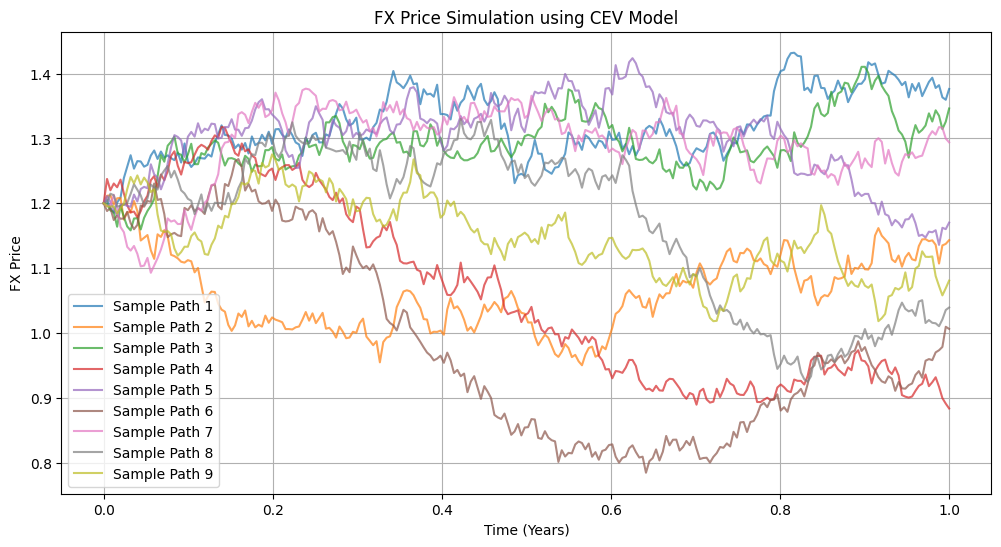

In [ ]:
def cev(S0, mu, sigma, gamma, T, steps):
    dt = T/steps
    prices = np.zeros(steps)
    prices[0] = S0

    for t in range(1, steps):
        dW = np.random.normal(0, np.sqrt(dt))
        prices[t] = prices[t-1] * (1 + mu*dt + sigma*(prices[t-1]**(gamma-1))*dW)

    return np.maximum(prices, 0)  # Ensure prices stay positive

# Parameters for CEV Model
S0 = 1.2          # Initial FX price
mu = 0.05         # Drift (average return)
sigma = 0.2       # Volatility
gamma = 0.75     # Elasticity of variance (between 0 and 1)
T = 1             # Total time (in years)
steps = 252       # Number of steps (e.g., daily over a year)


plt.figure(figsize=(12,6))
for i in range(9):
  S=cev(S0, mu, sigma, gamma, T, steps)
  plt.plot(time, S, label=f"Sample Path {i+1}", alpha=0.7)

plt.title("FX Price Simulation using CEV Model")
plt.xlabel("Time (Years)")
plt.ylabel("FX Price")
plt.legend()
plt.grid(True)
plt.show()

Nice, so we have many ways to simulate them, but we want to find which one is the more accurate. We are going to evaluate their performance compare to real data fetch from yahoo finance. Review this part bc didn't succed at scaling the simulated data and the one fetched from yf at the same time interval.

BACKTESTING

fisrt we imported real data from yf. Back test done in three time scales. One wcomparing with historical data, one comparing recent fetch from yf on 5 month, daily data, and one with 60 days of 5 min data

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EURUSD=X']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (5m 2024-12-14 -> 2024-12-24) (Yahoo error = "5m data not available for startTime=1734134400 and endTime=1734998400. The requested range must be within the last 60 days.")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetched 9813 data points
Price                         Close      High       Low      Open   Volume
Ticker                     EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X
Datetime                                                                  
2024-12-24 00:00:00+00:00  1.040583  1.040799  1.040583  1.040691        0
2024-12-24 00:05:00+00:00  1.040475  1.040583  1.040475  1.040583        0
2024-12-24 00:10:00+00:00  1.040475  1.040583  1.040475  1.040583        0
2024-12-24 00:15:00+00:00  1.040366  1.040475  1.040366  1.040475        0
2024-12-24 00:20:00+00:00  1.040475  1.040475  1.040366  1.040366        0


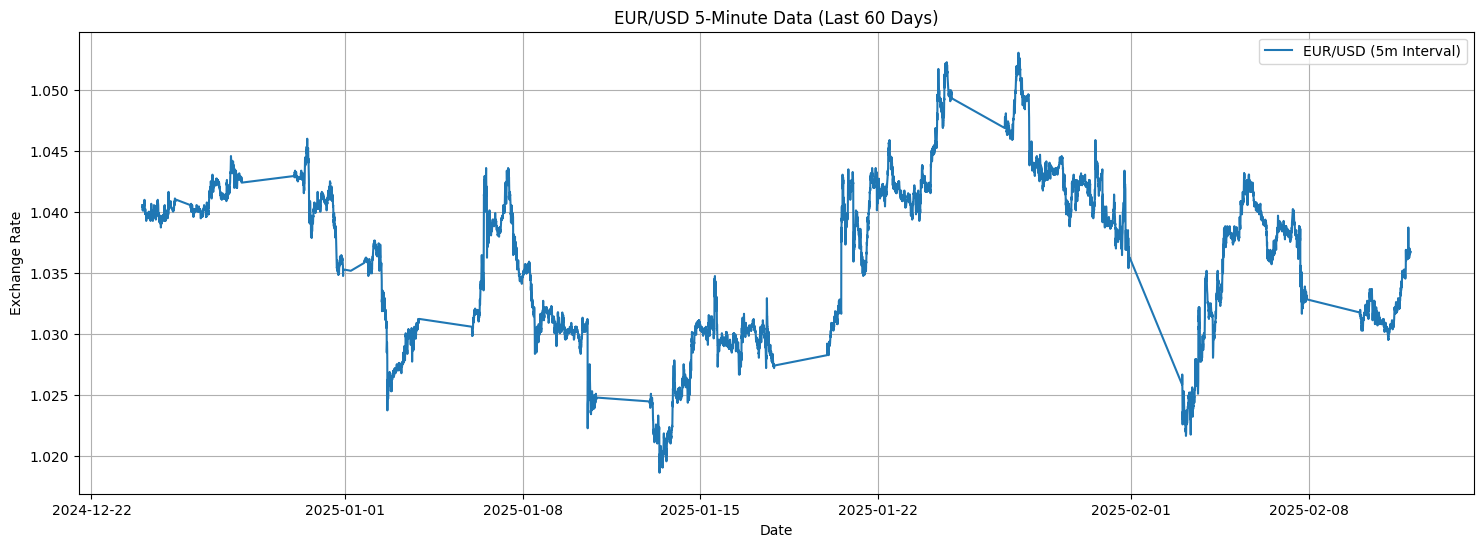

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

# Define parameters
ticker = "EURUSD=X"
end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=60)  # Max allowed for 5-min data
interval = "5m"

# Fetch data in chunks (10-day increments to avoid API limits)
all_data = []
chunk_size = 10
current_start = start_date

while current_start < end_date:
    current_end = min(current_start + dt.timedelta(days=chunk_size), end_date)
    data = yf.download(ticker, start=current_start, end=current_end, interval=interval)

    if not data.empty:
        all_data.append(data)

    current_start = current_end

# Combine chunks into a single DataFrame
fx_data_5m = pd.concat(all_data).dropna()

# Print summary
print(f"Fetched {len(fx_data_5m)} data points")
print(fx_data_5m.head())

# Plot data
plt.figure(figsize=(18, 6))
plt.plot(fx_data_5m.index, fx_data_5m["Close"], label="EUR/USD (5m Interval)")
plt.title("EUR/USD 5-Minute Data (Last 60 Days)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetched 969 hourly data points


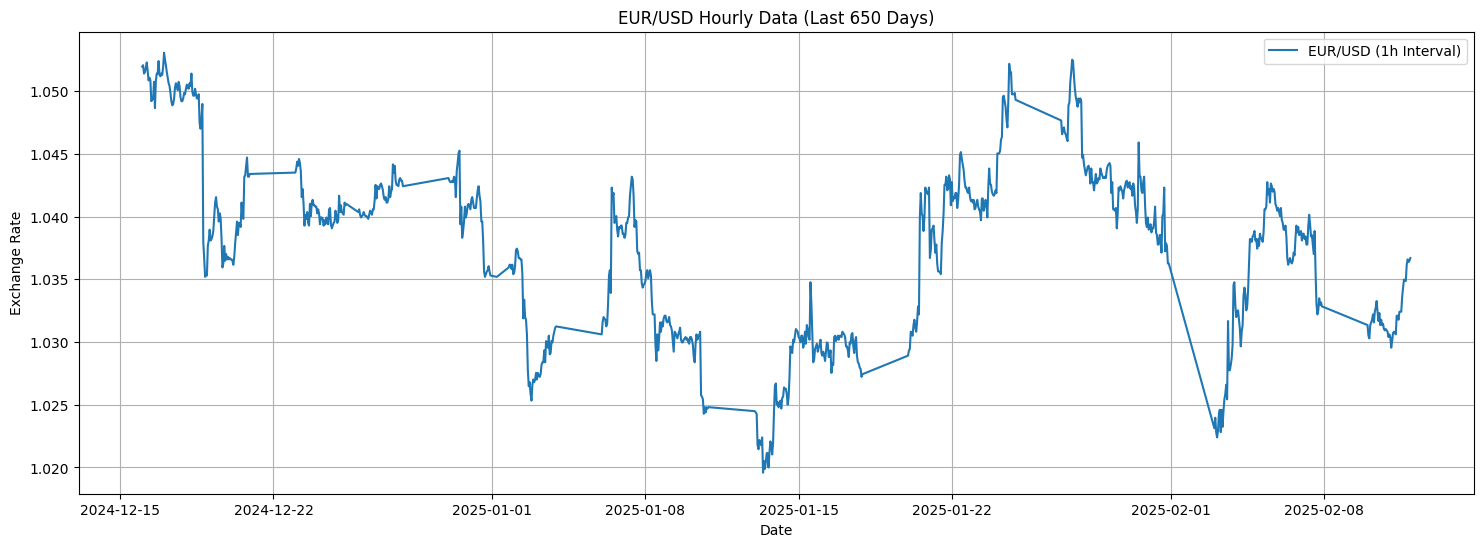

In [ ]:
chunk_size = 10
current_start = start_date
start_date = end_date - dt.timedelta(days=650)
interval = "1h"  # Use hourly instead of 5-min

# Same fetching method
all_data_1h = []
while current_start < end_date:
    current_end = min(current_start + dt.timedelta(days=chunk_size), end_date)
    data = yf.download(ticker, start=current_start, end=current_end, interval=interval)

    if not data.empty:
        all_data_1h.append(data)

    current_start = current_end

# Combine and use in memory
fx_data_1h = pd.concat(all_data_1h).dropna()
print(f"Fetched {len(fx_data_1h)} hourly data points")

# Plot data
plt.figure(figsize=(18, 6))
plt.plot(fx_data_1h.index, fx_data_1h["Close"], label="EUR/USD (1h Interval)")
plt.title("EUR/USD Hourly Data (Last 650 Days)")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

recall that in the previous part we implemented all these methods :
- GBM: Simple, good for short-term forecasting
- Heston: Better for options pricing, captures volatility smiles
- GARCH: Good for risk management, captures volatility clustering
- OU: Good for mean-reverting pairs
- CEV: Good for capturing asymmetric volatility
- Merton Jump (supposed to be the best)
We worked on a one year scale with daily simulated prices, but since we want to work in a 5 min time interval we need to adjuste them to short time simulayion. The previous part was more an overview of what they can produce.

Backetest for 5 min interval during 60 days

<ipython-input-4-c822c9cbc2dc>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices[0] = S0
<ipython-input-5-3d35b283d983>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices[0] = S0
<ipython-input-6-54be4774c2fd>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices[0] = S0
<ipython-input-2-41ea1083d1ee>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from

GBM - MSE: 0.000132, RMSE: 0.011478, MAE: 0.009266
Heston - MSE: 0.582726, RMSE: 0.763365, MAE: 0.686998
GARCH - MSE: 0.017113, RMSE: 0.130817, MAE: 0.108783
OU - MSE: 0.269386, RMSE: 0.519024, MAE: 0.470860
CEV - MSE: 0.000212, RMSE: 0.014558, MAE: 0.011836
Merton Jump - MSE: 0.066779, RMSE: 0.258416, MAE: 0.242358


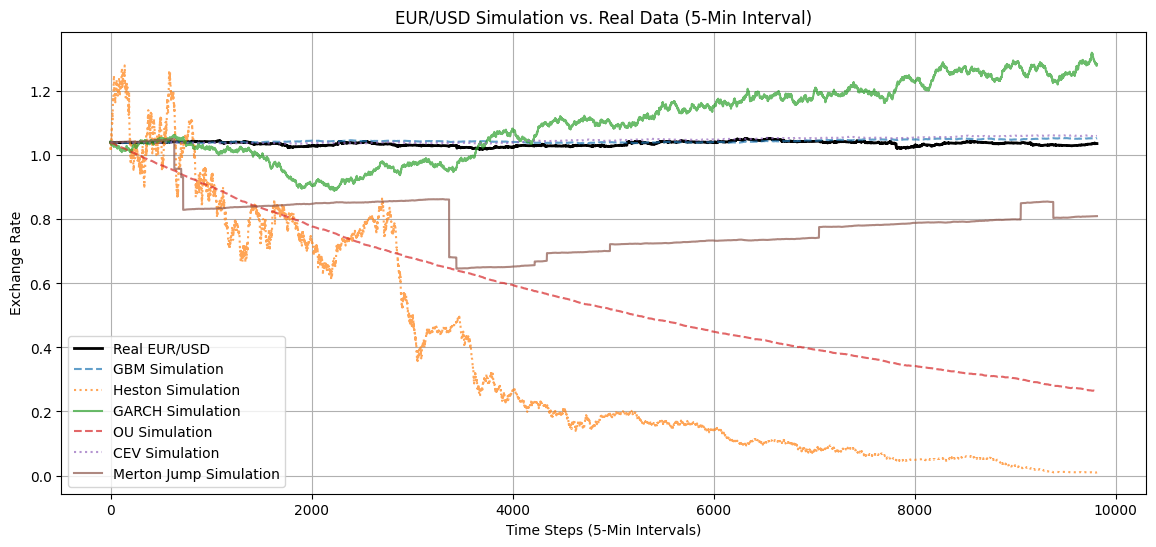

In [ ]:
fx_prices = fx_data_5m['Close'].values  # Use 'Close' column as the price
time_steps = np.arange(len(fx_prices))  # Time axis for simulation

S0 = fx_prices[0]  # Start simulation from the first real data point
T = len(fx_prices) / (24 * 12)  # Convert time steps into fraction of a day
steps = len(fx_prices)  # Match real data points
mu = 0.0001  # Small drift per 5 minutes
sigma = 0.002  # Volatility scaled for 5 minutes


gbm_sim = gbm(S0, mu, sigma, T, steps)
heston_sim = heston(S0, v0, kappa, theta, xi, rho, mu, T, steps)  # Make sure heston is adapted to 5-min
garch_sim = garch(S0, omega, alpha, beta, mu, sigma_scale, T, steps)   # Adjust GARCH for short-term forecasting
ou_sim = ou(S0, mu, theta, sigma, T, steps)        # OU model for mean reversion
cev_sim = cev(S0, mu, sigma, gamma, T, steps)      # CEV for capturing volatility asymmetry
merton_sim = merton_jump(S0, mu, sigma, lambda_, mu_j, sigma_j, T, steps) # Merton Jump Simulation


def compute_metrics(real, simulated, model_name):
    mse = mean_squared_error(real, simulated)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real, simulated)  # Adding MAE

    print(f"{model_name} - MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}")


compute_metrics(fx_prices, gbm_sim, "GBM")
compute_metrics(fx_prices, heston_sim, "Heston")
compute_metrics(fx_prices, garch_sim, "GARCH")
compute_metrics(fx_prices, ou_sim, "OU")
compute_metrics(fx_prices, cev_sim, "CEV")
compute_metrics(fx_prices, merton_sim[1], "Merton Jump")

plt.figure(figsize=(14, 6))
plt.plot(time_steps, fx_prices, label="Real EUR/USD", color="black", linewidth=2)
plt.plot(time_steps, gbm_sim, label="GBM Simulation", linestyle="dashed", alpha=0.7)
plt.plot(time_steps, heston_sim, label="Heston Simulation", linestyle="dotted", alpha=0.7)
plt.plot(time_steps, garch_sim, label="GARCH Simulation", linestyle="-", alpha=0.7)
plt.plot(time_steps, ou_sim, label="OU Simulation", linestyle="--", alpha=0.7)
plt.plot(time_steps, cev_sim, label="CEV Simulation", linestyle=":", alpha=0.7)
plt.plot(time_steps, merton_sim[1], label="Merton Jump Simulation", linestyle="solid", alpha=0.7)

plt.title("EUR/USD Simulation vs. Real Data (5-Min Interval)")
plt.xlabel("Time Steps (5-Min Intervals)")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

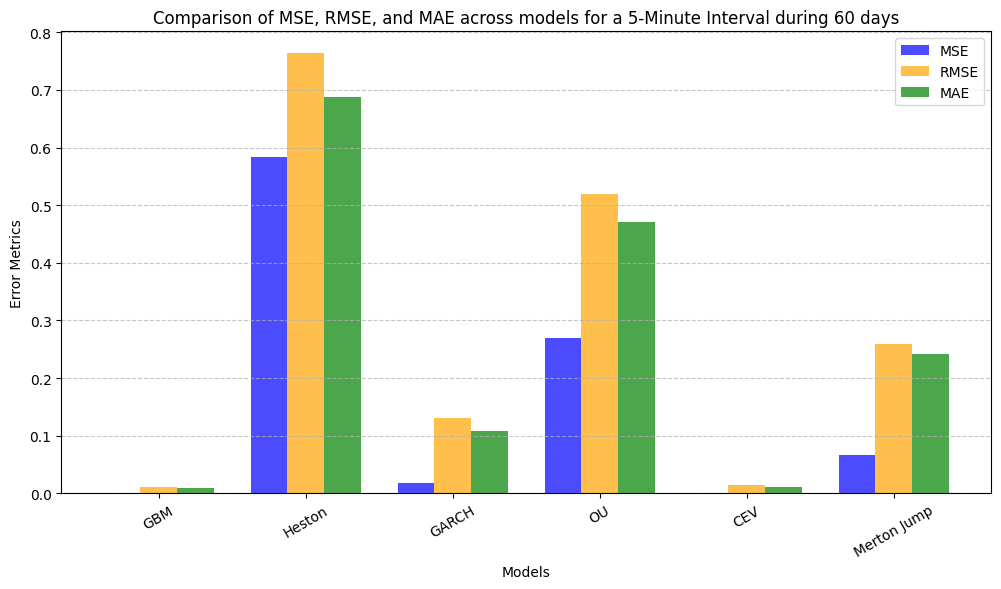

9813


In [ ]:
# Define the models and their simulated outputs
models = {
    "GBM": gbm_sim,
    "Heston": heston_sim,
    "GARCH": garch_sim,
    "OU": ou_sim,
    "CEV": cev_sim,
    "Merton Jump": merton_sim[1]  # Using the second return value (price path)
}

# Initialize lists to store metric values
mse_values, rmse_values, mae_values = [], [], []

# Compute and store metrics for each model
for model_name, simulated in models.items():
    mse = mean_squared_error(fx_prices, simulated)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(fx_prices, simulated)

    mse_values.append(mse)
    rmse_values.append(rmse)
    mae_values.append(mae)

# Plot the results
x_labels = list(models.keys())
x = np.arange(len(models))  # X-axis positions

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.25
ax.bar(x - bar_width, mse_values, bar_width, label="MSE", color="blue", alpha=0.7)
ax.bar(x, rmse_values, bar_width, label="RMSE", color="orange", alpha=0.7)
ax.bar(x + bar_width, mae_values, bar_width, label="MAE", color="green", alpha=0.7)

ax.set_xlabel("Models")
ax.set_ylabel("Error Metrics")
ax.set_title("Comparison of MSE, RMSE, and MAE across models for a 5-Minute Interval during 60 days")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=30)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

print(len(fx_data_5m))

Backtest for a 1H 180 days

GBM - MSE: 0.001071, RMSE: 0.032733, MAE: 0.028713
Heston - MSE: 0.769855, RMSE: 0.877414, MAE: 0.849626
GARCH - MSE: 0.030851, RMSE: 0.175644, MAE: 0.152455
OU - MSE: 0.323108, RMSE: 0.568425, MAE: 0.517362
CEV - MSE: 0.000374, RMSE: 0.019330, MAE: 0.015751
Merton Jump - MSE: 0.013528, RMSE: 0.116312, MAE: 0.091986


<ipython-input-4-c822c9cbc2dc>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices[0] = S0
<ipython-input-5-3d35b283d983>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices[0] = S0
<ipython-input-6-54be4774c2fd>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prices[0] = S0
<ipython-input-2-41ea1083d1ee>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from

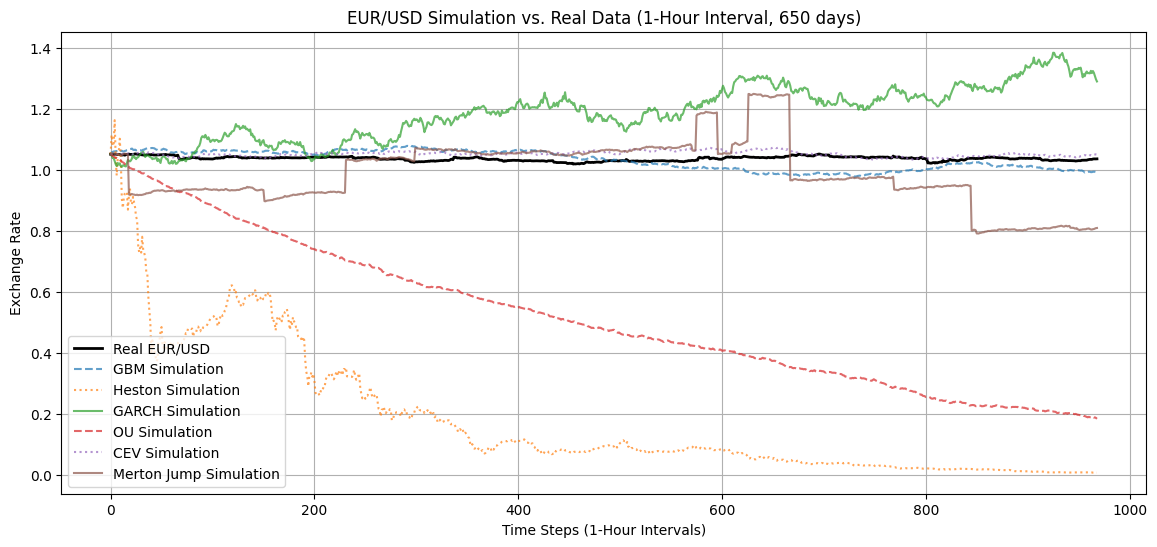

In [ ]:
fx_prices = fx_data_1h['Close'].values  # Use 'Close' column for prices
time_steps = np.arange(len(fx_prices))  # Time axis for simulation

S0 = fx_prices[0]  # Start simulation from the first real data point
T = len(fx_prices) / 24  # Convert time steps into fraction of days (1h intervals)
steps = len(fx_prices)  # Match real data points

# Adjusted volatility for hourly intervals
mu = 0.0001  # Small drift per hour
sigma = 0.0069  # Adjusted volatility for hourly intervals (scaling from 5-min)


gbm_sim = gbm(S0, mu, sigma, T, steps)
heston_sim = heston(S0, v0, kappa, theta, xi, rho, mu, T, steps)  # Adapted for hourly steps
garch_sim = garch(S0, omega, alpha, beta, mu, sigma_scale, T, steps)  # Adjusted for short-term
ou_sim = ou(S0, mu, theta, sigma, T, steps)  # Mean-reverting OU
cev_sim = cev(S0, mu, sigma, gamma, T, steps)  # CEV for volatility asymmetry
merton_sim = merton_jump(S0, mu, sigma, lambda_, mu_j, sigma_j, T, steps)  # Merton Jump


def compute_metrics(real, simulated, model_name):
    mse = mean_squared_error(real, simulated)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real, simulated)  # Added MAE

    print(f"{model_name} - MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}")


compute_metrics(fx_prices, gbm_sim, "GBM")
compute_metrics(fx_prices, heston_sim, "Heston")
compute_metrics(fx_prices, garch_sim, "GARCH")
compute_metrics(fx_prices, ou_sim, "OU")
compute_metrics(fx_prices, cev_sim, "CEV")
compute_metrics(fx_prices, merton_sim[1], "Merton Jump")


plt.figure(figsize=(14, 6))
plt.plot(time_steps, fx_prices, label="Real EUR/USD", color="black", linewidth=2)
plt.plot(time_steps, gbm_sim, label="GBM Simulation", linestyle="dashed", alpha=0.7)
plt.plot(time_steps, heston_sim, label="Heston Simulation", linestyle="dotted", alpha=0.7)
plt.plot(time_steps, garch_sim, label="GARCH Simulation", linestyle="-", alpha=0.7)
plt.plot(time_steps, ou_sim, label="OU Simulation", linestyle="--", alpha=0.7)
plt.plot(time_steps, cev_sim, label="CEV Simulation", linestyle=":", alpha=0.7)
plt.plot(time_steps, merton_sim[1], label="Merton Jump Simulation", linestyle="solid", alpha=0.7)

plt.title("EUR/USD Simulation vs. Real Data (1-Hour Interval, 650 days)")
plt.xlabel("Time Steps (1-Hour Intervals)")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid(True)
plt.show()

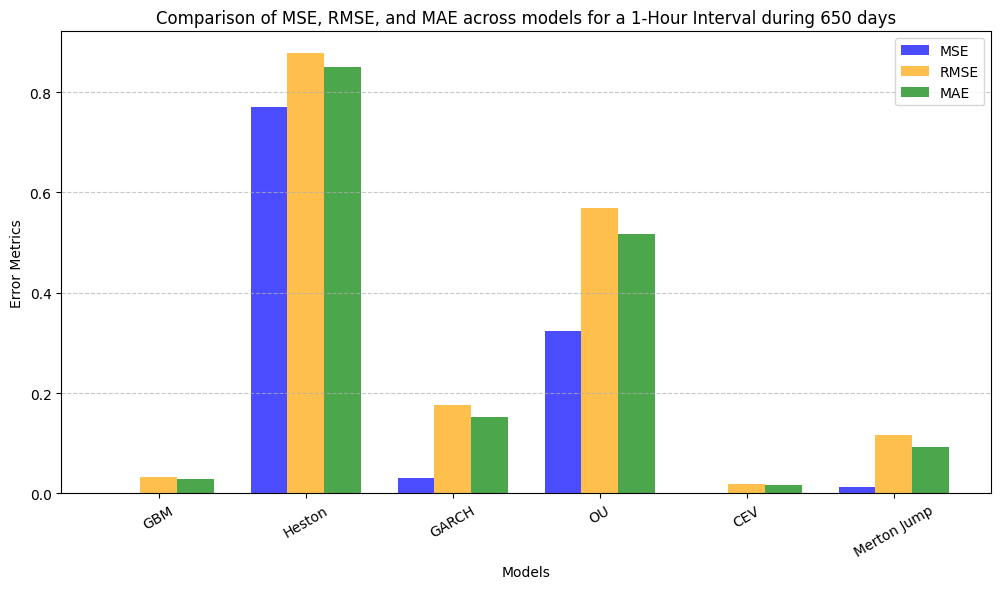

969


In [ ]:
# Define the models and their simulated outputs
models = {
    "GBM": gbm_sim,
    "Heston": heston_sim,
    "GARCH": garch_sim,
    "OU": ou_sim,
    "CEV": cev_sim,
    "Merton Jump": merton_sim[1]  # Using the second return value (price path)
}

# Initialize lists to store metric values
mse_values, rmse_values, mae_values = [], [], []

# Compute and store metrics for each model
for model_name, simulated in models.items():
    mse = mean_squared_error(fx_prices, simulated)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(fx_prices, simulated)

    mse_values.append(mse)
    rmse_values.append(rmse)
    mae_values.append(mae)

# Plot the results
x_labels = list(models.keys())
x = np.arange(len(models))  # X-axis positions

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.25
ax.bar(x - bar_width, mse_values, bar_width, label="MSE", color="blue", alpha=0.7)
ax.bar(x, rmse_values, bar_width, label="RMSE", color="orange", alpha=0.7)
ax.bar(x + bar_width, mae_values, bar_width, label="MAE", color="green", alpha=0.7)

ax.set_xlabel("Models")
ax.set_ylabel("Error Metrics")
ax.set_title("Comparison of MSE, RMSE, and MAE across models for a 1-Hour Interval during 650 days")
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=30)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

print(len(fx_data_1h))

We can evaluate all the models on multiple timeframes, even with historical data. Now we can try to find the best parameters to add for every model to fit perfectly the data. In this part of the study we will remove some of the least performing algorithm and focus on the more promizing ones.
